In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymssql
from datetime import datetime, timedelta

(1000, 2) (1000, 2)
   Id  Quantity
0   0        52
1   1        53
   Id  Quantity
0   0        57
1   1        74


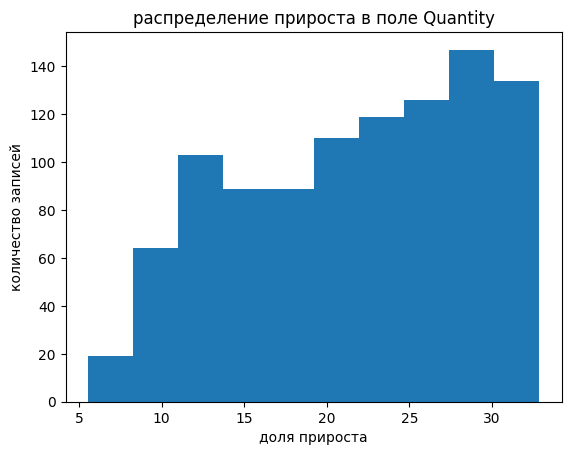

In [2]:
task1_t1 = pd.DataFrame([{'Id':id, 'Quantity':np.random.randint(10, 100)} for id in range(1000)])
task1_t2 = task1_t1.copy()
task1_t2['Quantity'] = task1_t2['Quantity'].apply(lambda q: int(q * np.random.randint(110, 150)/100))
print(task1_t1.shape, task1_t2.shape)
print(task1_t1.head(2))
print(task1_t2.head(2))
plt.hist(100 - (task1_t1['Quantity'] / task1_t2['Quantity'] * 100))
plt.ylabel('количество записей')
plt.xlabel('доля прироста')
plt.title('распределение прироста в поле Quantity')
plt.show()



In [3]:
with pymssql.connect(server='95.165.31.67:1433',
                     user='sa',
                     password='Pass1sF@ke',
                     database='test') as conn:
    with conn.cursor() as cursor:
        for t_name, data in zip(['task1_t1', 'task1_t2'], [task1_t1, task1_t2]):
            print(t_name, 'processing', len(data), 'rows')
            query = f'''insert into dbo.{t_name} (Quantity) values (%d)'''
            cursor.executemany(query, list(data['Quantity'].astype(str).values))
            conn.commit()

task1_t1 processing 1000 rows
task1_t2 processing 1000 rows


In [7]:
date_start = datetime(2020, 1, 1)
task2_t1 = pd.DataFrame([{'Id':id, 'Quantity':np.random.randint(10, 100), 'Data':date_start + timedelta(days=id)} for id in range(1000)])
print(task2_t1.shape)
task2_t1.head(2)

(1000, 3)


,Id,Quantity,Data
0,0,58,2020-01-01
1,1,76,2020-01-02


In [18]:
date_start = datetime(2020, 1, 1)
dts = []
for i in range(1000):
    if i > 0:
        date_start += timedelta(hours=np.random.randint(1, 12))
    dts.append(date_start)
task2_t1 = pd.DataFrame([{'Id':id, 'Quantity':np.random.randint(10, 100), 'Data':dts[id]} for id in range(1000)])
print(task2_t1.shape)
task2_t1.head(2)

(1000, 3)


,Id,Quantity,Data
0,0,35,2020-01-01 00:00:00
1,1,18,2020-01-01 06:00:00


In [19]:
with pymssql.connect(server='95.165.31.67:1433',
                     user='sa',
                     password='Pass1sF@ke',
                     database='test') as conn:
    with conn.cursor() as cursor:
        query = f'''insert into dbo.task2_t1_v2 (Quantity, Data) values (%d, %s)'''
        cursor.executemany(query, list(map(tuple, task2_t1[['Quantity', 'Data']].astype(str).values)))
        conn.commit()

In [20]:
task3_t1 = pd.DataFrame([{'Id':id, 'Quantity':np.random.randint(10, 10000)} for id in range(1000)])
print(task3_t1.shape)
task3_t1.head(2)

(1000, 2)


,Id,Quantity
0,0,4231
1,1,4092


In [26]:
task3_t1.to_csv('data/task3_t1_v2.csv', index=False)

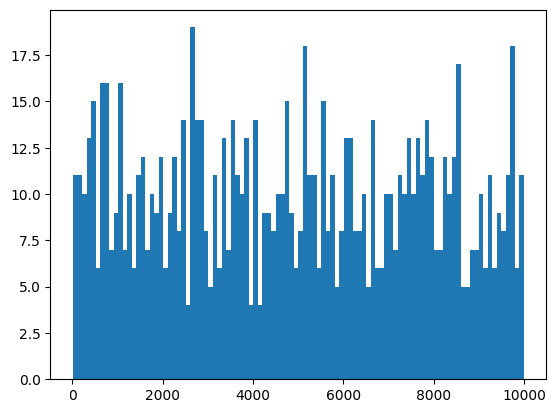

In [27]:
plt.hist(task3_t1['Quantity'].values, bins=100)
plt.show()

In [106]:
def test_diff(data_old, data_new, index, value):
    print(data_old['Quantity'].sum() == data_new['Quantity'].sum())
    old_q = data_old[data_old['Id']==index]['Quantity']
    new_q = data_new[data_new['Id']==index]['Quantity']
    if value > 0:
        diff_sum = (old_q/new_q).mean()
    else:
        diff_sum = (new_q/old_q).mean()
    print(1 - diff_sum)

def update_q(data, index, value):
    new_data = data.copy()
    new_data.set_index('Id', drop=True)
    new_data.loc[index, 'Quantity'] += value
    
    new_data.sort_values('Quantity', inplace=True, ascending=False)
    new_data['diff'] = .0
    n_row = 0
    offset = 1 if value < 0 else -1
    while value != 0:
        i, q, _ = new_data.iloc[n_row].values
        i = int(i)
        q = int(q)
        if i == index:
            continue
        new_q = int(q + offset)
        diff = 1 - (q / new_q if value < 0 else new_q / q)
        if diff <= new_data.iloc[0, -1] or n_row==0:
            new_data.loc[i, 'diff'] = diff
            new_data.loc[i, 'Quantity'] = new_q
            value += offset
            n_row += 1
        else:
            n_row = 0
    new_data.sort_index(ascending=True, inplace=True)
    new_data.drop(columns=['diff'], inplace=True)
    new_data.reset_index(drop=False, inplace=True)
        
    return new_data

In [109]:
index = 13
value = 215
test_diff(task3_t1, update_q(task3_t1, index, value), index, value)

True
0.038627380524613675


In [94]:
index = 13
value = 215
new_data = task3_t1.copy()
old_q_sum = new_data['Quantity'].sum()
new_data.set_index('Id', drop=True)
new_data.loc[index, 'Quantity'] += value

4895788


In [95]:
new_data.sort_values('Quantity', inplace=True, ascending=False)
new_data['diff'] = .0
n_row = 0
offset = 1 if value < 0 else -1
while value != 0:
    i, q, _ = new_data.iloc[n_row].values
    i = int(i)
    q = int(q)
    if i == index:
        continue
    new_q = int(q + offset)
    diff = 1 - (q / new_q if value < 0 else new_q / q)
    if diff <= new_data.iloc[0, -1] or n_row==0:
        new_data.loc[i, 'diff'] = diff
        new_data.loc[i, 'Quantity'] = new_q
        value += offset
        n_row += 1
    else:
        n_row = 0
new_data.sort_index(ascending=True, inplace=True)

In [93]:
new_data['Quantity'].sum()

4895788

In [80]:
new_data

,Id,Quantity,diff
0,0,4231,0.0
1,1,4092,0.0
2,2,5964,0.0
3,3,4403,0.0
4,4,5828,0.0
...,...,...,...
995,995,9094,0.0
996,996,6923,0.0
997,997,4385,0.0
998,998,8099,0.0


False
0.0


In [25]:
with pymssql.connect(server='95.165.31.67:1433',
                     user='sa',
                     password='Pass1sF@ke',
                     database='test') as conn:
    with conn.cursor() as cursor:
        query = f'''insert into dbo.task3_t1_v2 (Id, Quantity) values (%d, %d)'''
        cursor.executemany(query, list(map(tuple, task3_t1.astype(str).values)))
        conn.commit()